In [438]:
# =================================================
# Your names:





# =================================================
# Automatic Speech Recognition WS-17-18
# Exercise 7, Task 7.2

# Please make use of the functions and the variables
# provided in this notebook when you write your answer codes.
import matplotlib.pyplot as plt
import numpy as np
from math import log
import sys

def Read(filename):
    x_data = []
    y_data = []
    # Read function:
    #   Reads the 2D data from the file path
    #   Returns a list for each component of the data.
    with open(filename) as f:
        data_str = f.readlines()
        for i in range(0, len(data_str)):
            data_point = data_str[i].split()
            x_data.append(float(data_point[0]))
            y_data.append(float(data_point[1]))
        return x_data, y_data

Let's see how the data look like.


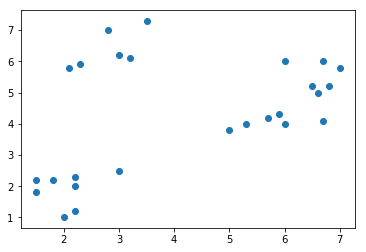

We can see 3 or 4 groups of points, right?

We will model this data with 4 densities (L=4).

[103.03884615384617, 86.65115384615385]
Initialization done.
Initial density:
Mean: [4.134615384615384, 4.273076923076923]
Variance: [3.9630325443786987, 3.3327366863905326]


In [439]:
# This is another helper code cell which introduces
# the name of variables to be used in your solution
# as well as the data you will use.
# The task starts at the next cell.

# Download the data from L2P and put the path here:
data = "./observations_ex7.data"
data_x, data_y = Read(data)

# Visualize the data
print("Let's see how the data look like.")
plt.scatter(data_x, data_y)
plt.show()

print("We can see 3 or 4 groups of points, right?\n")
print("We will model this data with 4 densities (L=4).\n")

# Set the hyperparameters given in the text:
L = 4  # Maximum number of densities
R = 10  # Number of iterations
eps_u = [0.1, 0.1]  # Vector: epsilon * u

# Number of data points:
N = len(data_x)

# Compute the initial mean
init_mean = [0.,0.]
for i in range(0,N):
    init_mean[0] += float(data_x[i])
    init_mean[1] += float(data_y[i])
init_mean[0] *= 1./float(N)
init_mean[1] *= 1./float(N)

# Compute the initial variance
init_var = [0., 0.]
for i in range(0,N):
    init_var[0] += (data_x[i]-init_mean[0])*(data_x[i]-init_mean[0])
    init_var[1] += (data_y[i]-init_mean[1])*(data_y[i]-init_mean[1])
print(init_var)
init_var[0] *= 1./float(N)
init_var[1] *= 1./float(N)

def Init():
    # Add the initial density to the list.
    global Mean
    Mean = []  # Mean is a list in which Mean[l] stores the mean vector for the density l.
    Mean.append(init_mean)
    
    global Var
    Var = init_var  # Pooled variance.
    
    global p_l
    p_l = []  # Array to store p(l) (cf. the notation given in the sheet).
    p_l.append(1)

    global N_l  # Array to store N_l (cf. the notation given in the sheet).
    N_l = np.zeros([L])  
    N_l = list(N_l)
    N_l[0] = N
    
    global A  # Array to store the membership of each point.
    A = np.zeros([N], dtype=np.int32)
    A = list(A)
    print('Initialization done.')
    
    global split_iteration
    split_iteration = np.zeros((L, N))

Init()
print('Initial density:')
print('Mean:', Mean[0])
print('Variance:', Var)

In [440]:
#   Functions for (a)
def Gaussian(x, mean, var):
    # Returns p(x|l) (cf. the notation given in the sheet)
    # You can use for example np.exp for the exponential
    # For the number 'pi', you can e.g. use 'np.pi'
    # TODO You code here
    exp_argument = (-0.5) * np.sum(np.divide(np.multiply((np.array(x) - np.array(mean)), (np.array(x) - np.array(mean))), np.array(var)))
    coeffic_variable = np.full(len(var), 2.0 * np.pi) * np.array(var)
    exp_coeffic = 1.0 / np.prod(np.sqrt(coeffic_variable)) #the case with pooled variance
    return (np.exp(exp_argument) * exp_coeffic)

def Assign(K):
    # Update the membership of each points
    # (list A introduced in the previous cell)
    # K: current number of densities
    # TODO You code here
    curr_max = np.zeros(N)
    for idx, val in enumerate(data_x):
        for cl in range(K):
            if ((p_l[cl] * Gaussian([val, data_y[idx]], Mean[cl], Var)) > curr_max[idx]):
                curr_max[idx] = p_l[cl] * Gaussian([val, data_y[idx]], Mean[cl], Var)
                A[idx] = cl

In [441]:
# Function for (c)
def EstimateParameters(K):
    # Re-estimate the means and variances for all densities
    # K: current number of densities
    # TODO You code here
    
    for cluster in range(K):
        one_hot = list(map(kronecker_delta, A, np.full(N, cluster)))
        N_l[cluster] = sum(one_hot)
        p_l[cluster] = float(N_l[cluster]) / float(N)
        Mean[cluster][0] = np.sum(np.multiply(one_hot, data_x)) / float(N_l[cluster])
        Mean[cluster][1] = np.sum(np.multiply(one_hot, data_y)) / float(N_l[cluster])
        
    var_1 = 0
    var_2 = 0
    for dp in range(0, N):
        var_1 += (data_x[dp] - Mean[A[dp]][0]) ** 2
        var_2 += (data_y[dp] - Mean[A[dp]][1]) ** 2
    Var = [var_1, var_2]
    Var[0] *= 1./float(N)
    Var[1] *= 1./float(N)
    

def kronecker_delta(cur_assignment, cluster):
    if (cluster == cur_assignment):
        return 1
    else:
        return 0

In [442]:
# Functions for (d)
def FindMinLogLike(K):
    # Return the index of the density with the lowest likelihood.
    # TODO You code here
    import sys
    ll = [sys.float_info.max] * K

    dataset = np.vstack((data_x, data_y)).T
    cond_prob = np.fromiter((Gaussian(x, Mean[A[id_x]], Var) for id_x, x in enumerate(dataset)), np.float)
    log_likelihood = [log(x * p_l[A[id_x]]) for id_x, x in enumerate(cond_prob)]
    
    for cluster in range(K):
        one_hot = list(map(kronecker_delta, A, np.full(N, cluster)))
        ll[cluster] = np.sum(np.multiply(one_hot, log_likelihood))
    return ll.index(np.min(ll))


def SplitDensity(l):
    # Split the density l.
    # If needed: When you have a list L, you can use L.pop(n) to remove the
    # element in position n of the list L.
    # TODO You code here
    
    mu = Mean[l]
    Mean.pop(l)
    Mean.append(np.array(mu) + np.array(eps_u))
    Mean.append(np.array(mu) - np.array(eps_u))
    
    new_weight = p_l[l]
    p_l.pop(l)
    p_l.append(new_weight)
    p_l.append(new_weight)
    
    N_l.pop(l)
    N_l.append(0)
    N_l.append(0)
    

In [450]:
Init()
# Apply the algorithm to the data.
# Report the mean, variance and membership for each split iteration.

# TODO You code here
k = 1
iteration = 0
while(k <= L):
    print(iteration)
    min_id = FindMinLogLike(k)
    SplitDensity(min_id)
    k += 1
    iteration += 1
    for iteration in range(0, R):
        Assign(k)
        EstimateParameters(k)
    print("Mean = ", Mean)
    print("Variance = ", Var)
    print("Current cluster assignment : ", A)
    split_iteration[k-2] = np.array(A)
    
    
print(split_iteration)
    
# Checkpoint: after the first split, you should get the following:
# Mean: [[5.06, 5.33], [2.05, 1.90]]
# Var: [3.96, 3.33]
# Membership: [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Initialization done.
0
Mean =  [array([ 5.06111111,  5.32777778]), array([ 2.05,  1.9 ])]
Variance =  [3.9630325443786987, 3.3327366863905326]
Current cluster assignment :  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9
Mean =  [array([ 2.05,  1.9 ]), array([ 6.18333333,  4.8       ]), array([ 2.81666667,  6.38333333])]
Variance =  [3.9630325443786987, 3.3327366863905326]
Current cluster assignment :  [0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
9
Mean =  [array([ 2.05,  1.9 ]), array([ 2.81666667,  6.38333333]), array([ 6.6       ,  5.53333333]), array([ 5.76666667,  4.06666667])]
Variance =  [3.9630325443786987, 3.3327366863905326]
Current cluster assignment :  [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2]
9
Mean =  [array([ 2.81666667,  6.38333333]), array([ 6.6       ,  5.53333333]), array([ 5.76666667,  4.06666667]), array([ 2.3 ,  2.25]), array([ 1.8 ,  1.55])]
Variance =  [3.9630

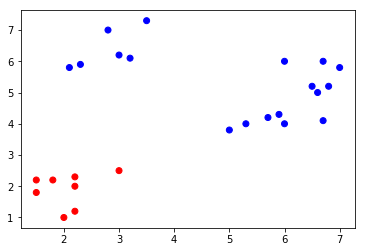

In [451]:
# Visualization of the split you obtained

# This cell is a helper to show you an example method to plot
# data points with different colors.

split_example = [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Colors = ['b', 'r', 'y', 'm']  # blue, red, yellow, magenta. No need to modify this list.

color = [Colors[split_example[i]] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()

# You will use the next cells below to plot your own results.

Split 0
[ 1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


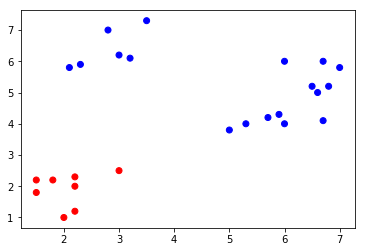

In [452]:
# Plot for the last question
# Split 0
print("Split 0")
# TODO You code here
print(split_iteration[0])
color = [Colors[int(split_iteration[0][i])] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()

Split 1
[ 0.  0.  0.  0.  2.  0.  0.  0.  2.  2.  0.  2.  2.  2.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.]


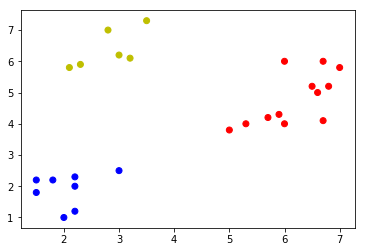

In [453]:
# Plot for the last question
# Split 1
print("Split 1")
# TODO You code here
print(split_iteration[1])
color = [Colors[int(split_iteration[1][i])] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()

Split 2
[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  3.  3.  3.  3.
  3.  2.  2.  2.  3.  2.  2.  2.]


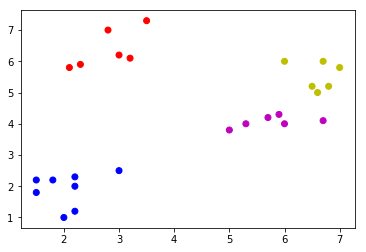

In [454]:
# Plot for the last question
# Split 2
print("Split 2")
# TODO You code here
print(split_iteration[2])
color = [Colors[int(split_iteration[2][i])] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()

In [458]:
# Plot for the last question
# Split 3
print("Split 3")
# TODO You code here
print(split_iteration[3])
color = [Colors[int(split_iteration[3][i])] for i in range(0, N)]  # List of the color for each data point.
plt.scatter(data_x, data_y, c=color)  # 'c' argument to provide the color for each point as a list.
plt.show()

Split 3
[ 4.  4.  3.  4.  0.  4.  3.  3.  0.  0.  3.  0.  0.  0.  2.  2.  2.  2.
  2.  1.  1.  1.  2.  1.  1.  1.]


IndexError: list index out of range

In [ ]:
# End of the exercise 7.2